This notebook will be used to create functions that will show the daily veocity plots with data that ahs been calculated every 15 minutes at the VENUS nodes.

#Plotting the Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import netCDF4 as nc
from dateutil import tz
import os
from glob import glob

from salishsea_tools import(viz_tools, tidetools,nc_tools)
from salishsea_tools.nowcast import (analyze, figures)
from IPython.display import Image
import datetime

%matplotlib inline

In [14]:
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '15', 'color': 'white',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '13', 'color' : 'white'}

In [2]:
filec='/data/dlatorne/MEOPAR/SalishSea/nowcast/10may15/VENUS_central_gridded.nc'
filee='/data/dlatorne/MEOPAR/SalishSea/nowcast/10may15/VENUS_east_gridded.nc'

grid_c=nc.Dataset(filec)
grid_e=nc.Dataset(filee)

In [3]:
def unstag_rot_15m(ugrid, vgrid, station):
    """Interpolate u and v component values to values at grid cell centre. Then rotates the 
    grid cells to align with N/E orientation.

    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`

    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray` 
    
    :arg station: Name of the station ('East' or 'Central')
    :type station: string    

    :returns u_E, v_N, depths: u_E and v_N velocties is the North and East directions at the cell center, 
    and the depth of the station
    """

    if station=='Central':
        depths=330
    else:
        depths=170

    #We need to access the u velocity that is between i and i-1
    u_t=(ugrid[:, :, 1, 0]+ugrid[:, :, 1, 1])/2
    v_t=(vgrid[:, :, 1, 1]+vgrid[:, :, 0, 1])/2
    theta=29 
    theta_rad=theta * np.pi /180

    u_E=u_t * np.cos(theta_rad) - v_t * np.sin(theta_rad)
    v_N=u_t * np.sin(theta_rad) + v_t * np.cos(theta_rad)
    return u_E, v_N, depths

In [27]:
def plot_vel_NE_15m(station, grid, figsize):
    """Plots the hourly averaged North/South and East/West velocities at a chosen 
    VENUS node station using data that is calculated every 15 minutes.
    
    :arg station: Name of the station ('East' or 'Central')
    :type station: string

    :arg grid_U_h: Hourly zonal velocity results dataset from NEMO.
    :type grid_U_h: :class:`netCDF4.Dataset`

    :arg grid_V_h: Hourly meridional velocity results dataset from NEMO.
    :type grid_V_h: :class:`netCDF4.Dataset`
    
    :arg grid_W_h: Hourly vertical velocity results dataset from NEMO.
    :type grid_W_h: :class:`netCDF4.Dataset`  

    :arg figsize: Figure size (width, height) in inches or 'default'.
    :type figsize: 2-tuple

    :returns: matplotlib figure object instance (fig).
    """
    
    u_u= grid.variables['vozocrtx']
    v_v= grid.variables['vomecrty']
    w_w= grid.variables['vovecrtz']
    dep_t= grid.variables['depthv']
    dep_w= grid.variables['depthw']

    u_E, v_N, dep_s=unstag_rot_15m(u_u, v_v,station)

    fig, (axu, axv, axw)=plt.subplots(3,1,figsize=figsize)
    fig.patch.set_facecolor('#2B3E50')
    
    vmax=0.65
    vmin=-vmax
    step=0.005

    #viz_tools.set_aspect(axu)
    timestamp=nc_tools.timestamp(grid,0)
    cmap=plt.get_cmap('jet')
    
    axu.invert_yaxis()
    mesh=axu.contourf(np.arange(96),dep_t[:], u_E.transpose(), np.arange(vmin, vmax, step),cmap=cmap)
    
    
    cbar=fig.colorbar(mesh,ax=axu)
    axu.set_ylim([dep_s,0])
    axu.set_xlim([0,95])
    axu.set_xlabel('Time [h]', **axis_font)
    axu.set_ylabel('Depth [m]', **axis_font)
    axu.set_title('East/West Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY')), **title_font) 
    cbar.set_label('[m/s]', **axis_font)

    axv.invert_yaxis()
    mesh=axv.contourf(np.arange(96),dep_t[:], v_N.transpose(), np.arange(vmin, vmax, step),cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axv)
    axv.set_ylim([dep_s,0])
    axv.set_xlim([0,95])
    axv.set_xlabel('Time [h]', **axis_font)
    axv.set_ylabel('Depth [m]', **axis_font)
    axv.set_title('North/South Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY')), **title_font) 
    cbar.set_label('[m/s]', **axis_font)
    
    axw.invert_yaxis()
    mesh=axw.contourf(np.arange(96), dep_w[:], w_w[:,:,1,1].transpose(), np.arange(vmin/100, vmax/100, step/100),cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axw)
    axw.set_ylim([dep_s,0])
    axw.set_xlim([0,95])
    axw.set_xlabel('Time [h]',**axis_font)
    axw.set_ylabel('Depth [m]', **axis_font)
    axw.set_title('Vertical Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY')), **title_font) 
    cbar.set_label('[m/s]', **axis_font)

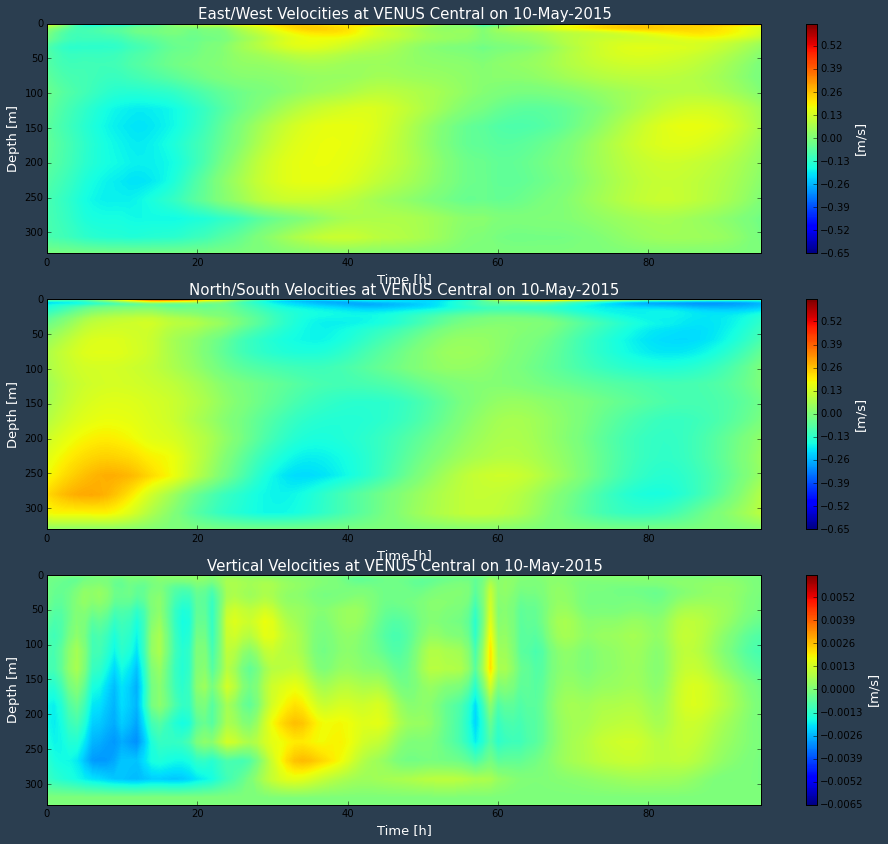

In [28]:
plot_vel_NE_15m('Central', grid_c, figsize=(16,14))

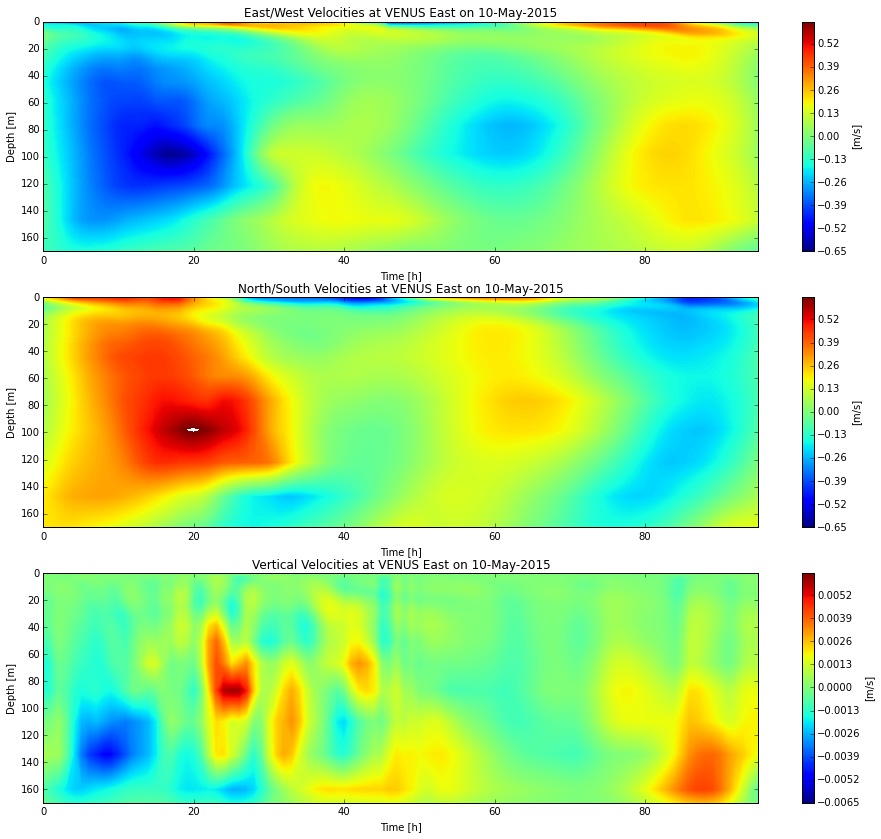

In [7]:
plot_vel_NE_15m('East', grid_e, figsize=(16,14))